# Жесткие системы ОДУ
### Расчет суточных колебаний концетраций озона в атмосфере

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Колебания концентраций задаются следующей системой уравнений 

$$ 
\begin{cases}
\dot y_1 = -k_1y_1y_2 - k_2y_1y_3 + 2k_3(t)y_2+k_4(t)y_3 \\
\dot y_2 = 0\\
\dot y_3 = k_1y_1y_2 - k_2y_1y_3 - k_4(t)y_3
\end{cases},
$$
где $y_1 = [O]$, $y_2 = [O_2]$, $y_3 = [O_3]$.

Начальные условия задачи при $t=0$:

In [2]:
atom_oxygen_init = 1e6 #cm^-1
molec_oxygen_init = 3.7e16 #cm^-1
ozone_init = 1e12 #cm^-1

Константы химических скоростей:

In [3]:
k1 = 1.63e-16
k2 = 4.66e-16
c3 = 22.62
c4 = 7.601
omega = np.pi/43200 # c^-1

class RateConst:
    def __init__(self, k1=k1, k2=k2, c3=c3, c4=c4, omega=omega):
        self.k1 = k1
        self.k2 = k2
        self.c3 = c3
        self.c4 = c4
        self.omega = omega
    
    def get_rate_const(self, t, c):
        if np.sin(self.omega*t)>0: 
            return np.exp(-c/np.sin(self.omega*t))
        else: return 0.0
        
    def k1(self, *args):
        return self.k1
    
    def k2(self, *args):
        return self.k2
    
    def k3(self, t):
        return self.get_rate_const(t=t, c=self.c3)

    def k4(self, t):
        return self.get_rate_const(t=t, c=self.c4)


In [4]:
rc = RateConst()

In [5]:
def F(t, x, rc = rc):
    x1 = -k1*molec_oxygen_init*x[0]-k2*x[0]*x[1]+2*rc.k3(t)*molec_oxygen_init+rc.k4(t)*x[1]
    x2 = rc.k1*molec_oxygen_init*x[0]-rc.k2*x[0]*x[1]-rc.k4(t)*x[1]
    return np.array([x1,x2])

In [6]:
from scipy.integrate import solve_ivp

In [7]:
start_time = 0
end_time = 172800

In [22]:
%time sol_bdf = solve_ivp(fun = F, t_span=(start_time, end_time), y0=np.array([atom_oxygen_init, ozone_init]), method='BDF', t_eval=np.linspace(0, 172800, 200000))

CPU times: user 201 ms, sys: 36 µs, total: 201 ms
Wall time: 201 ms


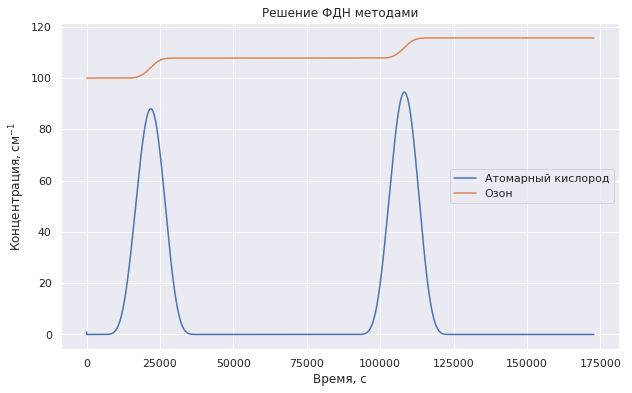

In [23]:
plt.plot(sol_bdf.t, sol_bdf.y[0,:]/1e6, label='Атомарный кислород')
plt.plot(sol_bdf.t, sol_bdf.y[1,:]/1e10,label='Озон')
plt.xlabel("Время, с")
plt.ylabel("Концентрация, "+"см$^{-1}$")
#plt.yscale('log')
plt.grid(True)
plt.legend(loc="best")
plt.title("Решение ФДН методами")
plt.rcParams["figure.figsize"] = (10, 6)
plt.show()

In [26]:
%time sol_implicitRK = solve_ivp(fun = F, t_span=(start_time, end_time), y0=np.array([atom_oxygen_init, ozone_init]), method='Radau', t_eval=np.linspace(0, 172800, 300000))

CPU times: user 89.4 ms, sys: 61 µs, total: 89.4 ms
Wall time: 88.5 ms


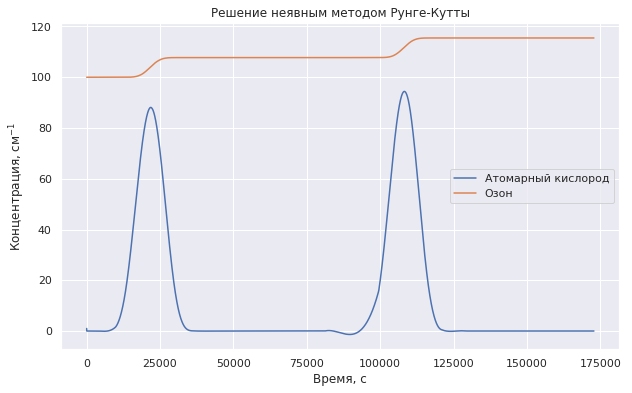

In [27]:
plt.plot(sol_implicitRK.t, sol_implicitRK.y[0,:]/1e6, label='Атомарный кислород')
plt.plot(sol_implicitRK.t, sol_implicitRK.y[1,:]/1e10,label='Озон')
plt.xlabel("Время, с")
plt.ylabel("Концентрация, "+"см$^{-1}$")
#plt.yscale('log')
plt.grid(True)
plt.legend(loc="best")
plt.title("Решение неявным методом Рунге-Кутты")
plt.rcParams["figure.figsize"] = (10, 6)
plt.show()

In [28]:
%time sol_explicitRK4 = solve_ivp(fun = F, t_span=(start_time, end_time), y0=np.array([atom_oxygen_init, ozone_init]), method='RK45', t_eval=np.linspace(0, 172800, 200000))

CPU times: user 1min 6s, sys: 62.2 ms, total: 1min 6s
Wall time: 1min 7s


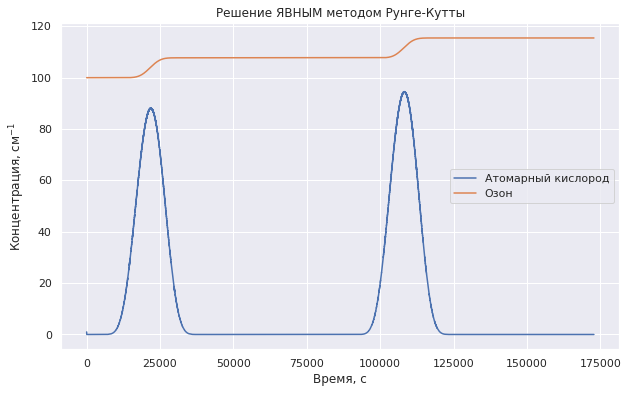

In [29]:
plt.plot(sol_explicitRK4.t, sol_explicitRK4.y[0,:]/1e6, label='Атомарный кислород')
plt.plot(sol_explicitRK4.t, sol_explicitRK4.y[1,:]/1e10,label='Озон')
plt.xlabel("Время, с")
plt.ylabel("Концентрация, "+"см$^{-1}$")
plt.grid(True)
plt.legend(loc="best")
plt.title("Решение ЯВНЫМ методом Рунге-Кутты")
plt.rcParams["figure.figsize"] = (10, 6)
plt.show()

__Выводы:__ несмотря на то, что явный метод Рунге-Кутты показал результаты близкие к результататм неявных методов, он дольше исполнялся из-за возросшего числа вычислений, что ожидаемо для явных методов при решении жеских систем. Наиболее качественный резульат показал метод дифференцирования назад. Так же заметим, что число озона возрастает. Это связано с модельным приближением, при котором количество кислорода в атмосфере остается постоянным.